In [1]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm


In [2]:
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor


print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

/home/aiden/miniconda3/envs/homeworkenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.1.1+cu121; Torch-cuda version: 12.1; Torch Geometric version: 2.4.0.


In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Software_5.json.gz --no-check-certificate
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Software.csv --no-check-certificate
!gzip -d Software_5.json.gz
!head Software_5.json
!head Software.csv
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Software.json.gz --no-check-certificate
!gzip -d meta_Software.json.gz
!head meta_Software.json

In [3]:
# set the seed for reproducibility
seed = 226
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
import pandas as pd
import json

# reviews = pd.read_csv("Gift_Cards.csv")
review_data = []
review_name = './Software_5.json'
with open(review_name, 'r') as file:
    for line in file:
      review_data.append(json.loads(line))
file_metadata = []
metadata_link = "./meta_Software.json"
with open(metadata_link, 'r') as file:
    for line in file:
      file_metadata.append(json.loads(line))

In [5]:
categories_names = []
for line in file_metadata:
    for cat in line['category']:
        if cat not in categories_names:
            categories_names.append(cat)
        

In [79]:
len(categories_names)

6956

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(categories_names)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

def vec_to_category(vector) -> str:
    return label_encoder.inverse_transform([np.argmax(vector)])[0]

def categories_to_vec(categories):
    categories = list(set(categories))
    integer_encoded = label_encoder.transform(categories)
    integer_encoded = integer_encoded.reshape(-1, 1)
    onehot_encoded = onehot_encoder.transform(integer_encoded)
    # print(onehot_encoded)
    output = onehot_encoded[0]
    for i in range(1, len(onehot_encoded)):
        output += onehot_encoded[i]
    return output



/home/aiden/miniconda3/envs/homeworkenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
review_df = pd.DataFrame(review_data,columns=['reviewerID','asin','overall'])
review_df.head()

,reviewerID,asin,overall
0,A38NELQT98S4H8,0321719816,4.0
1,A3QJU4FEN8PQSZ,0321719816,4.0
2,ACJT8MUC0LRF0,0321719816,5.0
3,AYUF7YETYOLNX,0321719816,5.0
4,A31ICLWQ9CSHRS,0321719816,5.0


In [9]:
from sentence_transformers import SentenceTransformer

class TextEncoder:
    """
    A class for encoding text using a SentenceTransformer model.
    """
    def __init__(self, model='all-MiniLM-L6-v2', device=None):
        """
        :param model: Name of the SentenceTransformer model to use.
        :param device: Device to use for model inference. Default is None.
        """
        self.device = device
        self.model = SentenceTransformer(model, device=self.device)

    @torch.no_grad()
    def __call__(self, values: list):
        """
        Encode a list of text values into embeddings.

        :param values: List of text values to encode.
        :return: Encoded embeddings as a PyTorch tensor.
        """
        x = self.model.encode(values,
                              show_progress_bar=True,
                              convert_to_tensor=True,
                              device=self.device)
        return x.cpu()


# Check if CUDA is available, and set the device accordingly
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Create an instance of the TextEncoder class with the determined device
encoder = TextEncoder(device=device)

2023-12-07 09:46:39.703823: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 09:46:39.828192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 09:46:40.383306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
metadata_df = pd.DataFrame(file_metadata,columns=['asin','category','title','description','also_buy'])
print(metadata_df.head())
len(metadata_df)

         asin category                                              title  \
0  0030672120       []  HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...   
1  0071480935       []  Sing, Watch, &amp; Learn Spanish (DVD + Guide)...   
2  007329506X       []  Connect with LearnSmart Access Card for Microb...   
3  0073513458       []  LearnSmart Standalone Access Card for Prescott...   
4  0073525758       []  Anatomy &amp; Physiology Revealed Student Acce...   

                                         description  \
0                                                 []   
1  [, <b>Latin rhythms that will get your kids si...   
2  [<b>Connect is the only integrated learning sy...   
3                                                 []   
4  [<i>Anatomy &amp; Physiology Revealed Cat</i> ...   

                               also_buy  
0                                    []  
1                                    []  
2                                    []  
3                               

26790

In [13]:
del review_data
del file_metadata

In [14]:
unique_user_id = review_df['reviewerID'].unique()
unique_user_id = pd.DataFrame(data={
   'userId': unique_user_id,
   'mappedID': pd.RangeIndex(len(unique_user_id)),
})

unique_product_id = metadata_df['asin'].unique()
unique_product_id = pd.DataFrame(data={
   'productId': unique_product_id,
   'mappedID': pd.RangeIndex(len(unique_product_id)),
})

In [80]:
print(f"We have {len(unique_user_id)} users and {len(unique_product_id)} products.")

We have 1826 users and 21639 products.


In [15]:
def one_hot(x):
    if len(x) == 0 :
        return np.zeros(shape=(len(onehot_encoded)))
    else:
        return categories_to_vec(x)

In [16]:
metadata_df["category"] = metadata_df["category"].apply(lambda x: one_hot(x))

In [17]:
product_features = torch.zeros(len(unique_product_id), 384 + len(onehot_encoded))
def convert_to_embed(x):
    product = x["asin"]
    mapped_id = unique_product_id.loc[unique_product_id['productId'] == product, 'mappedID'].values[0]
    one_hot =  torch.tensor(x["category"])
    d = ' '.join(x["description"])
    if d == "":
        product_features[mapped_id] = torch.cat((encoder("None"), one_hot), -1)
    else:
        product_features[mapped_id] = torch.cat((encoder(d), one_hot), -1)

In [18]:
metadata_df.apply(lambda x : convert_to_embed(x),axis=1)
print(product_features.shape)

Batches: 100%|██████████| 1/1 [00:00<00:00, 397.94it/s]


torch.Size([21639, 7340])


In [19]:
product_product_edges = []
for product_id in metadata_df["asin"].unique():
   product = metadata_df[metadata_df["asin"] == product_id].iloc[0]
   if len(product["also_buy"]) == 0 :
       continue
   for also_bought_product in product["also_buy"]:
       if (unique_product_id['productId'] == also_bought_product).any():
           product_product_edges.append([unique_product_id.loc[unique_product_id['productId'] == product_id, 'mappedID'].values[0],
                                     unique_product_id.loc[unique_product_id['productId'] == also_bought_product, 'mappedID'].values[0]])
product_product_edges = torch.t(torch.tensor(product_product_edges, dtype=torch.long))
print(product_product_edges.shape)


torch.Size([2, 7253])


In [20]:
user_product_edges = []
user_product_ratings = []
for review in review_df.itertuples():
   user_product_edges.append([unique_user_id.loc[unique_user_id['userId'] == review.reviewerID, 'mappedID'].values[0],
                              unique_product_id.loc[unique_product_id['productId'] == review.asin, 'mappedID'].values[0]])
   user_product_ratings.append(review.overall)
user_product_edges = torch.t(torch.tensor(user_product_edges, dtype=torch.long))
user_product_ratings = torch.tensor(user_product_ratings, dtype=torch.float) 
print(user_product_edges.shape)

torch.Size([2, 12805])


In [21]:
from torch_geometric.data import HeteroData
data = HeteroData()

# Add node features to the HeteroData object
data['Product'].x = product_features
# data['User'].x = torch.ones(len(users), 1)
data['User'].x = torch.eye(len(review_df['reviewerID'].unique()))

# Add edge indices to the HeteroData object
data['User', 'REVIEWS', 'Product'].edge_index = user_product_edges
data['User', 'REVIEWS', 'Product'].edge_label = user_product_ratings
data['Product', 'ALSO_BOUGHT', 'Product'].edge_index = product_product_edges

import torch_geometric.transforms as T
data = T.ToUndirected()(data)

del data['Product', 'rev_REVIEWS', 'User'].edge_label


In [81]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.05,
    neg_sampling_ratio=0.0,
    edge_types=[('User', 'REVIEWS', 'Product'), ('Product', 'ALSO_BOUGHT', 'Product')],
    rev_edge_types=[('Product', 'rev_REVIEWS', 'User'),('Product', 'rev_ALSO_BOUGHT', 'Product')],
)(data)
train_data, val_data

# train_data, val_data, test_data = T.RandomLinkSplit(
#     num_val=0.1,
#     num_test=0.1,
#     neg_sampling_ratio=0.0,
#     edge_types=[('User', 'REVIEWS', 'Product')],
#     rev_edge_types=[('Product', 'rev_REVIEWS', 'User')],
# )(data)
train_data, val_data

(HeteroData(
   Product={ x=[21639, 7340] },
   User={ x=[1826, 1826] },
   (User, REVIEWS, Product)={
     edge_index=[2, 11525],
     edge_label=[11525],
     edge_label_index=[2, 11525],
   },
   (Product, ALSO_BOUGHT, Product)={
     edge_index=[2, 9662],
     edge_label=[9662],
     edge_label_index=[2, 9662],
   },
   (Product, rev_REVIEWS, User)={ edge_index=[2, 11525] },
   (Product, rev_ALSO_BOUGHT, Product)={}
 ),
 HeteroData(
   Product={ x=[21639, 7340] },
   User={ x=[1826, 1826] },
   (User, REVIEWS, Product)={
     edge_index=[2, 11525],
     edge_label=[640],
     edge_label_index=[2, 640],
   },
   (Product, ALSO_BOUGHT, Product)={
     edge_index=[2, 9662],
     edge_label=[536],
     edge_label_index=[2, 536],
   },
   (Product, rev_REVIEWS, User)={ edge_index=[2, 11525] },
   (Product, rev_ALSO_BOUGHT, Product)={}
 ))

In [82]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['User'][row], z_dict['Product'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        edge_index_dict = {k: v.to(torch.long).view(2, -1) for k, v in edge_index_dict.items()}
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [83]:
train_data.edge_index_dict

{('User',
  'REVIEWS',
  'Product'): tensor([[  141,  1601,   984,  ...,   436,  1031,  1281],
         [13896, 15671, 14560,  ..., 10404, 20899, 17154]]),
 ('Product',
  'ALSO_BOUGHT',
  'Product'): tensor([[19356, 21190, 15601,  ..., 20008, 15847,  5637],
         [20800, 15320, 20648,  ..., 21400, 13041,  3546]]),
 ('Product',
  'rev_REVIEWS',
  'User'): tensor([[13896, 15671, 14560,  ..., 10404, 20899, 17154],
         [  141,  1601,   984,  ...,   436,  1031,  1281]])}

In [92]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['User', 'Product'].edge_label_index)
    target = train_data['User', 'Product'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

epochs = 100
t_loss = []
v_loss = []
for epoch in range(1, epochs):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    t_loss.append(train_rmse)
    v_loss.append(val_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 0.6417, Train: 1.6481, Val: 1.7187
Epoch: 002, Loss: 2.7180, Train: 0.9445, Val: 1.0557
Epoch: 003, Loss: 0.8990, Train: 1.1616, Val: 1.2162
Epoch: 004, Loss: 2.0506, Train: 0.9617, Val: 1.0666
Epoch: 005, Loss: 1.1019, Train: 0.8721, Val: 1.0144
Epoch: 006, Loss: 0.7618, Train: 1.0795, Val: 1.1939
Epoch: 007, Loss: 1.1652, Train: 1.1244, Val: 1.2321
Epoch: 008, Loss: 1.2644, Train: 0.9873, Val: 1.1080
Epoch: 009, Loss: 0.9752, Train: 0.8531, Val: 0.9856
Epoch: 010, Loss: 0.7328, Train: 0.8956, Val: 1.0024
Epoch: 011, Loss: 0.8697, Train: 0.9536, Val: 1.0417
Epoch: 012, Loss: 1.0669, Train: 0.9122, Val: 1.0106
Epoch: 013, Loss: 0.9270, Train: 0.8493, Val: 0.9697
Epoch: 014, Loss: 0.7387, Train: 0.8703, Val: 0.9962
Epoch: 015, Loss: 0.7592, Train: 0.9362, Val: 1.0545
Epoch: 016, Loss: 0.8771, Train: 0.9533, Val: 1.0701
Epoch: 017, Loss: 0.9092, Train: 0.9077, Val: 1.0301
Epoch: 018, Loss: 0.8247, Train: 0.8526, Val: 0.9796
Epoch: 019, Loss: 0.7298, Train: 0.8442, Val: 

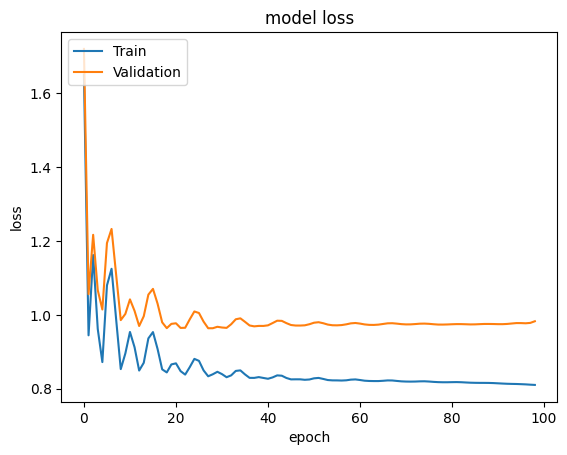

In [93]:
import matplotlib.pyplot as plt
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [94]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

userId = test_data['User', 'Product'].edge_label_index[0].cpu().numpy()
prodId = test_data['User', 'Product'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'ProdId': prodId, 'rating': pred, 'target': target}))

Test RMSE: 1.1265
     userId  ProdId      rating      target
0       548   11359 4.397669792 5.000000000
1      1599   17263 4.763520241 4.000000000
2      1680   15443 4.946063519 4.000000000
3       489    8656 3.842685223 4.000000000
4       621    8665 0.810777724 1.000000000
..      ...     ...         ...         ...
635    1653   19632 5.000000000 5.000000000
636      20   20727 0.781638205 1.000000000
637     868   10827 2.795109510 1.000000000
638     502    9032 3.520170689 4.000000000
639    1500   20746 4.469539642 4.000000000

[640 rows x 4 columns]


In [95]:
model

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [96]:
from torch_geometric.nn import GATConv, GCNConv


In [97]:

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels,heads = 2, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels,heads = 1, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['User'][row], z_dict['Product'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        edge_index_dict = {k: v.to(torch.long).view(2, -1) for k, v in edge_index_dict.items()}
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): GATConv((-1, -1), 32, heads=2)
      (Product__ALSO_BOUGHT__Product): GATConv((-1, -1), 32, heads=2)
      (Product__rev_REVIEWS__User): GATConv((-1, -1), 32, heads=2)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): GATConv((-1, -1), 32, heads=1)
      (Product__ALSO_BOUGHT__Product): GATConv((-1, -1), 32, heads=1)
      (Product__rev_REVIEWS__User): GATConv((-1, -1), 32, heads=1)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [102]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['User', 'Product'].edge_label_index)
    target = train_data['User', 'Product'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

epochs = 150
t_loss = []
v_loss = []
for epoch in range(1, epochs):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    t_loss.append(train_rmse)
    v_loss.append(val_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 0.8019, Train: 1.6485, Val: 1.5769
Epoch: 002, Loss: 10.8443, Train: 1.1179, Val: 1.1145
Epoch: 003, Loss: 1.3848, Train: 1.3810, Val: 1.4846
Epoch: 004, Loss: 1.9119, Train: 1.9785, Val: 2.0473
Epoch: 005, Loss: 3.9181, Train: 2.0565, Val: 2.0894
Epoch: 006, Loss: 4.2303, Train: 1.9644, Val: 1.9665
Epoch: 007, Loss: 3.8680, Train: 1.8165, Val: 1.7948
Epoch: 008, Loss: 3.3399, Train: 1.6192, Val: 1.5824
Epoch: 009, Loss: 2.6830, Train: 1.3940, Val: 1.3589
Epoch: 010, Loss: 1.9991, Train: 1.1987, Val: 1.1761
Epoch: 011, Loss: 1.4895, Train: 1.1284, Val: 1.1191
Epoch: 012, Loss: 1.3274, Train: 1.1816, Val: 1.1608
Epoch: 013, Loss: 1.4950, Train: 1.2269, Val: 1.1962
Epoch: 014, Loss: 1.6765, Train: 1.2097, Val: 1.1840
Epoch: 015, Loss: 1.6157, Train: 1.1478, Val: 1.1406
Epoch: 016, Loss: 1.3977, Train: 1.0935, Val: 1.1042
Epoch: 017, Loss: 1.2376, Train: 1.0919, Val: 1.1093
Epoch: 018, Loss: 1.2292, Train: 1.1266, Val: 1.1416
Epoch: 019, Loss: 1.3047, Train: 1.1450, Val:

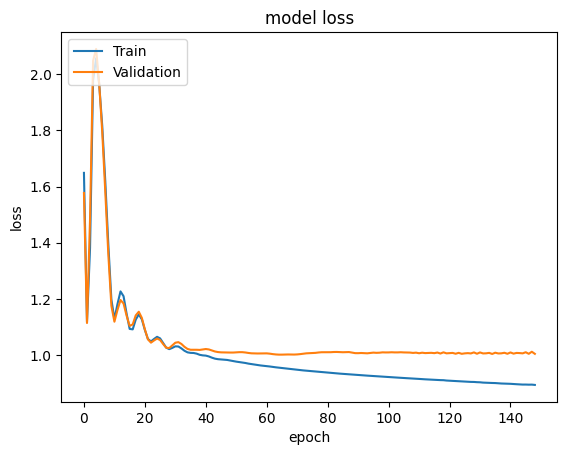

In [103]:
import matplotlib.pyplot as plt
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [104]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

userId = test_data['User', 'Product'].edge_label_index[0].cpu().numpy()
prodId = test_data['User', 'Product'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'ProdId': prodId, 'rating': pred, 'target': target}))

Test RMSE: 1.2272
     userId  ProdId      rating      target
0       548   11359 4.211375237 5.000000000
1      1599   17263 5.000000000 4.000000000
2      1680   15443 4.172961712 4.000000000
3       489    8656 4.315719604 4.000000000
4       621    8665 0.901820958 1.000000000
..      ...     ...         ...         ...
635    1653   19632 4.808533669 5.000000000
636      20   20727 0.207811251 1.000000000
637     868   10827 3.611551046 1.000000000
638     502    9032 4.416830063 4.000000000
639    1500   20746 5.000000000 4.000000000

[640 rows x 4 columns]


In [105]:
max_reviews_reviewer = review_df.groupby('reviewerID').size().idxmax()
random_user = review_df['reviewerID'].sample(1).values[0]


In [106]:
random_user

'A1V3PCKVCJ3TTZ'

In [107]:
mapped_user_id = unique_user_id.loc[unique_user_id['userId'] == random_user, 'mappedID'].values[0]
print(mapped_user_id)
products_rated = review_df[review_df['reviewerID'] == random_user]
products_not_rated = metadata_df[~metadata_df.asin.isin(products_rated['asin'])]
products_not_rated = products_not_rated.merge(unique_product_id, left_on='asin', right_on='productId', how='inner')
product = products_not_rated.sample(1)

329


In [108]:
product_id_mapped = product["mappedID"].item()

In [109]:
edge_label_index = torch.tensor([
    mapped_user_id,
    product_id_mapped])


with torch.no_grad():
    test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict, edge_label_index)
    pred = pred.clamp(min=0, max=5).detach().cpu().numpy()
print(pred.item())

2.6427907943725586


In [110]:
from torch_geometric.explain import Explainer, CaptumExplainer

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type=None,
    edge_mask_type='object',
)

explanation = explainer(
    test_data.x_dict, test_data.edge_index_dict, index=0,
    edge_label_index=edge_label_index).cpu().detach()
explanation

HeteroExplanation(
  prediction=[1],
  target=[1],
  index=[1],
  edge_label_index=[2],
  Product={ x=[21639, 7340] },
  User={ x=[1826, 1826] },
  (User, REVIEWS, Product)={
    edge_mask=[12165],
    edge_index=[2, 12165],
  },
  (Product, ALSO_BOUGHT, Product)={
    edge_mask=[10198],
    edge_index=[2, 10198],
  },
  (Product, rev_REVIEWS, User)={
    edge_mask=[12165],
    edge_index=[2, 12165],
  }
)

In [111]:
prod_id = unique_product_id.loc[unique_product_id['mappedID'] == product_id_mapped, 'productId'].values[0]
title = metadata_df.loc[metadata_df["asin"] == prod_id,"title"].values[0]
user_to_product = explanation['User', 'Product'].edge_index.numpy().T
user_to_product_attr = explanation['User', 'Product'].edge_mask.numpy().T
user_to_product_df = pd.DataFrame(
    np.hstack([user_to_product, user_to_product_attr.reshape(-1,1)]),
    columns = ['mappedUserId', 'mappedProductId', 'attr']
)

product_to_user = explanation['Product', 'User'].edge_index.numpy().T
product_to_user_attr = explanation[ 'Product', 'User'].edge_mask.numpy().T
product_to_user_df = pd.DataFrame(
    np.hstack([product_to_user, product_to_user_attr.reshape(-1,1)]),
    columns = ['mappedProductId', 'mappedUserId','attr']
)
explanation_df = pd.concat([user_to_product_df, product_to_user_df])
explanation_df[["mappedUserId", "mappedProductId"]] = explanation_df[["mappedUserId", "mappedProductId"]].astype(int)

print(f"Attribtion for all edges towards prediction of Product rating of Product:\n {title}")
print("==========================================================================================")
print(explanation_df.sort_values(by='attr'))

Attribtion for all edges towards prediction of Product rating of Product:
 Norton Internet Security 2014 21.0 1 User 3 PC Product Key Only Delivered Via Amazon email; No Media/CD/
       mappedUserId  mappedProductId         attr
5628            842            10477 -0.009799232
9918            842            10477 -0.009799232
9511            911            11873 -0.001943301
11676           329            10477 -0.001075845
11792           329            10477 -0.001075845
...             ...              ...          ...
6427            329            11391  0.008029822
6594            329            14680  0.013954108
9563            329             2208  0.081579760
11229           329             8072  0.087752499
2645            329             5072  0.104297726

[24330 rows x 3 columns]


In [112]:
print(prod_id)
metadata_df.loc[metadata_df["asin"] == "B000JMFKQI"]

B00HZ08P2S


,asin,category,title,description,also_buy
14230,B000JMFKQI,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Type to Learn 3 Single Edit,[],[]


In [113]:
explanation_df = explanation_df[explanation_df['mappedUserId'] == mapped_user_id]
print(explanation_df)
explanation_df = explanation_df.groupby('mappedProductId').sum()
explanation_df = explanation_df.merge(unique_product_id, left_on='mappedProductId', right_on='mappedID', how='inner')
explanation_df = explanation_df.merge(metadata_df, left_on='productId', right_on='asin', how='inner')
pd.options.display.float_format = "{:,.9f}".format

print("Top products that influenced the prediction:")
print("==============================================")
print(explanation_df.sort_values(by='attr', ascending=False, key= lambda x: abs(x))[['title', 'attr']].head())

       mappedUserId  mappedProductId         attr
1001            329            20876  0.000000005
2645            329             5072  0.000011004
3047            329            15671 -0.000000015
3792            329            10432  0.000000016
6427            329            11391  0.000000083
6594            329            14680  0.000000002
9563            329             2208  0.000009682
9751            329            11873  0.000000071
9929            329            10322  0.000001558
10914           329            10432  0.000000016
11149           329            10322  0.000001558
11159           329            17259  0.000000000
11229           329             8072  0.000010156
11676           329            10477 -0.001075845
11792           329            10477 -0.001075845
1001            329            20876  0.004294846
2645            329             5072  0.104297726
3047            329            15671 -0.000226238
3792            329            10432  0.000632463
